In [1]:
#!pipenv install pandas
import pandas as pd
#!pipenv install seaborn
import seaborn as sns
#!pipenv install ipywidgets
import ipywidgets as widgets

In [2]:
# Load the data
df = pd.read_csv("data.csv")
# Remove missing data and keep only useful columns
df = df.loc[
    df['Value'] != "No data", 
    ['ParentLocation', 'Location', 'Period', 'Dim1', 'Value']
]
# Rename columns
df.columns = ['ParentLocation', 'Location', 'Period', 'Gender', 'Prevalence']

# Some values in Prevalence contain ranges (like '13.4 [8.7 – 18.9]'), so we just keep the average
df['Prevalence'] = df['Prevalence'].apply(
    lambda x: float(x.split('[')[0]) if '[' in x else x
)

df.head()

,ParentLocation,Location,Period,Gender,Prevalence
0,Africa,Ethiopia,2016,Male,13.4
1,Africa,Uganda,2016,Male,13.7
2,Africa,Burundi,2016,Male,13.9
3,Africa,Niger,2016,Male,14.6
4,Africa,Eritrea,2016,Male,14.7


# Seaborn

<Figure size 1500x1000 with 0 Axes>

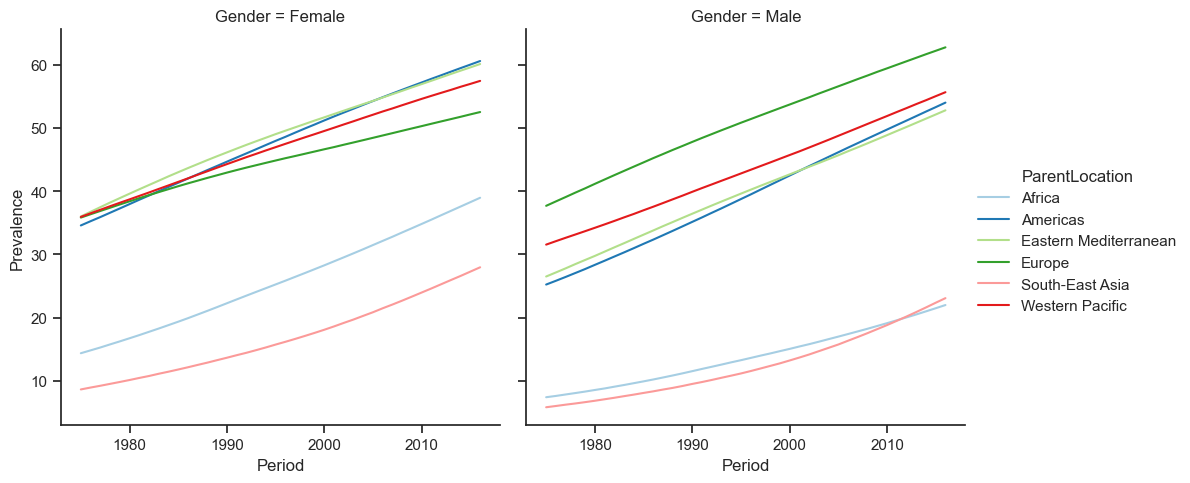

In [33]:
# Apply the style
sns.set_style("ticks")
sns.despine()

# Prepare df for this graph
grouped_df = df.groupby(
    ['ParentLocation', 'Gender', 'Period']
)['Prevalence'].mean().reset_index()

# Create visualization
sns.relplot(
    data=grouped_df[
        grouped_df['Gender'] != 'Both sexes'
    ],
    kind="line",
    x="Period", 
    y="Prevalence", 
    col="Gender",
    hue="ParentLocation", 
    palette="Paired"
)

In [37]:
import ipywidgets as widgets

countries = sorted(pd.unique(df['Location']))

# Creates Dropdown Widget
def create_dd(desc, i=0):
    dd = widgets.Dropdown(
        options=countries, 
        value=countries[i], 
        description=desc
    )
    return dd

# Creates the relplot
def draw_relplot(country1, country2):
    sns.relplot(
        data=df[
            (df['Location'].isin([country1, country2]))
            & (df['Gender'] != 'Both sexes')
        ],
        kind="line",
        x="Period", 
        y="Prevalence", 
        col="Gender",
        hue="Location", 
        palette="Paired"
    )

# Generate the final widget
dd1 = create_dd('Country 1', 0)
dd2 = create_dd('Country 2', 1)
ui = widgets.HBox([dd1, dd2])

# Create the interactive plot and display
out = widgets.interactive_output(
    draw_relplot, 
    {'country1': dd1, 'country2': dd2}
)

display(ui, out)

Output()

# Bokeh

In [4]:
#!pipenv install bokeh
#!pipenv install jupyter_bokeh
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.palettes import Paired

In [5]:
grouped_df = df.groupby(
    ['ParentLocation', 'Gender', 'Period']
)['Prevalence'].mean().reset_index()

from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.layouts import row
from bokeh.palettes import Paired

def prepare_figure(gender):
    l = figure(
        title=f"Gender = {gender}", 
        x_axis_label='Period', 
        y_axis_label='Prevalence',
        width=475, 
        outer_width=475,
        height=500,
    )
    for i, loc in enumerate(pd.unique(grouped_df['ParentLocation'])):
        l.line(
            grouped_df[
                (grouped_df['Gender'] == gender) 
                & (grouped_df['ParentLocation']==loc)
            ]['Period'], 
            grouped_df[
                (grouped_df['Gender'] == gender) 
                & (grouped_df['ParentLocation']==loc)
            ]['Prevalence'], 
            legend_label=loc, 
            line_width=2,
            color=Paired[12][i]
        )
        
    l.legend.location = 'top_left'
    l.legend.click_policy="mute"
    l.legend.label_text_font_size='8px'
    l.legend.background_fill_alpha = 0.4
        
    return l

# Render the figure inline
output_notebook()

# Create the first figure and input the data
l1=prepare_figure('Female')

# Create the second figure and input the data
l2=prepare_figure('Male')

p = row(l1, l2)

# Show the plot
show(p)

Loading BokehJS ...

# Plotly

In [7]:
#!pipenv install plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

countries = sorted(pd.unique(df['Location']))

def create_dd(desc, i=0):
    dd = widgets.Dropdown(
        options=countries, 
        value=countries[i], 
        description=desc
    )
    return dd

# Define variables
colors = ['#a6cee3', '#1f78b4']

# Define widgets (using previous function)
dd1 = create_dd('Country 1', 0)
dd2 = create_dd('Country 2', 1)

def create_figure(country1, country2):
    # Create figure and traces
    fig = make_subplots(
        shared_xaxes=True, 
        shared_yaxes=True, 
        rows=1, 
        cols=2,
        vertical_spacing = 0,
        subplot_titles=("Gender = Female", "Gender = Male"),

    )

    for j, gender in enumerate(['Female', 'Male']):
        for i, loc in enumerate([country1, country2]):
            fig.add_trace(
                go.Scatter(
                    x=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Period'], 
                    y=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Prevalence'], 
                    name=loc, 
                    line=go.scatter.Line(color=colors[i]), 
                    hovertemplate=None,
                    showlegend=False if j==0 else True
                ), 
                row=1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across")
    fig.update_layout(
        hovermode="x",
        template='simple_white'
    )
    return fig
    
fig = create_figure(countries[0], countries[1])

# Create the Figure Widget
g = go.FigureWidget(
    data = fig,
    layout=go.Layout(
        barmode='overlay'
    )
)

# Handle what to do when the DD value changes
def response(change):
    df_1 = df[
        (df['Gender'] == 'Female') 
        & (df['Location'] == dd1.value)
    ]
    df_2 = df[
        (df['Gender'] == 'Female') 
        & (df['Location'] == dd2.value)
    ]
    df_3 = df[
        (df['Gender'] == 'Male')
        & (df['Location'] == dd1.value)
    ]
    df_4 = df[
        (df['Gender'] == 'Male') 
        & (df['Location'] == dd2.value)
    ]
    
    x = [
        df_1['Period'], df_2['Period'], 
        df_3['Period'], df_4['Period']
    ]
    y = [
        df_1['Prevalence'], df_2['Prevalence'], 
        df_3['Prevalence'], df_4['Prevalence']
    ]
    with g.batch_update():
        for i in range(len(g.data)):
            g.data[i].x = x[i]
            g.data[i].y = y[i]
            g.data[i].name = dd1.value if i%2 == 0 else dd2.value

        g.layout.barmode = 'overlay'
        g.layout.xaxis.title = 'Period'
        g.layout.yaxis.title = 'Prevalence'


dd1.observe(response, names="value")
dd2.observe(response, names="value")

container = widgets.HBox([dd1, dd2])
widgets.VBox([container, g])


# Dash

In [3]:
#!pipenv install dash
#!pipenv install jupyter-dash
import dash_core_components as dcc
from dash import html
import plotly.graph_objects as go
from jupyter_dash import JupyterDash

app = JupyterDash(__name__)

/var/folders/h5/x4kfssld5_18qx4_3v8pdx6c0000gn/T/ipykernel_33554/2654641398.py:3: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc


In [157]:
# Create app
app = JupyterDash(__name__)

# dropdown menu options
country_options = [{'label': country, 'value': country} for country in df['Location'].unique()]
country_options = list(df['Location'].unique())


app.layout = html.Div([
    # Dropdown menu
    html.Div([ 
        html.H1('Countries'), 
        html.Div(
            [dcc.Dropdown(
                id='country1_dropdown',
                options=df['Location'].unique().tolist(),
                value='',
                placeholder='Select a country',
                style={'margin-bottom': '10px', 'max-width': '200px'}
            ),
             dcc.Dropdown(
                 id='country2_dropdown',
                 options=df['Location'].unique().tolist(),
                 value='',
                 placeholder='Select a country',
                 style={'max-width': '200px'}
            )]
        )
    ], style={
        'grid-column-start' : 'first',
        'grid-column-end' : 'second',
        'padding': '2%',
        'justify-self': 'center'
    }),

    # Plot
    html.Div([
        dcc.Graph(
            id='chart', 
            style={}
        )
    ], style={
        'grid-column-start' : 'second',
        'grid-column-end' : 'third',
    })
], style={
    'width': '100vw'
    'display': 'inline-grid',
    'grid-template-columns': '[first] 15% [second] 60% [third] 25%',
    'grid-template-rows': '[row] 100%',
    'grid-gap': '1rem',
    'align-items': 'right',
})

colors = ['#a6cee3', '#1f78b4'] 

@app.callback(
    dash.dependencies.Output('chart', 'figure'),
    dash.dependencies.Input('country1_dropdown', 'value'),
    dash.dependencies.Input('country2_dropdown', 'value')
)
def update_chart(country1, country2):   
    
    # Create figure and traces
    fig = make_subplots(
        shared_xaxes=True, 
        shared_yaxes=True, 
        rows=1, 
        cols=2,
        vertical_spacing = 0,
        subplot_titles=("Gender = Female", "Gender = Male"),

    )

    for j, gender in enumerate(['Female', 'Male']):
        for i, loc in enumerate([country1, country2]):
            fig.add_trace(
                go.Scatter(
                    x=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Period'], 
                    y=df[
                        (df['Gender'] == gender) 
                        & (df['Location'] == loc)
                    ]['Prevalence'], 
                    name=loc, 
                    line=go.scatter.Line(color=colors[i]), 
                    hovertemplate=None,
                    showlegend=False if j==0 else True
                ), 
                row=1, 
                col=j+1 
            )

    # Prettify
    fig.update_xaxes(showspikes=True, spikemode="across")
    fig.update_layout(
        hovermode="x",
        template='simple_white',
    )

    return fig

# Run app
if __name__ == '__main__':
    app.run_server()

Dash is running on http://127.0.0.1:8050/

Dash app running on http://127.0.0.1:8050/


In [61]:
country_options

[{'label': 'Ethiopia', 'value': 'Ethiopia'},
 {'label': 'Uganda', 'value': 'Uganda'},
 {'label': 'Burundi', 'value': 'Burundi'},
 {'label': 'Niger', 'value': 'Niger'},
 {'label': 'Eritrea', 'value': 'Eritrea'},
 {'label': 'Malawi', 'value': 'Malawi'},
 {'label': 'Rwanda', 'value': 'Rwanda'},
 {'label': 'Viet Nam', 'value': 'Viet Nam'},
 {'label': 'Chad', 'value': 'Chad'},
 {'label': 'Kenya', 'value': 'Kenya'},
 {'label': 'Burkina Faso', 'value': 'Burkina Faso'},
 {'label': 'Madagascar', 'value': 'Madagascar'},
 {'label': 'India', 'value': 'India'},
 {'label': 'Democratic Republic of the Congo',
  'value': 'Democratic Republic of the Congo'},
 {'label': 'Mozambique', 'value': 'Mozambique'},
 {'label': 'Bangladesh', 'value': 'Bangladesh'},
 {'label': 'Comoros', 'value': 'Comoros'},
 {'label': 'Central African Republic', 'value': 'Central African Republic'},
 {'label': 'Cambodia', 'value': 'Cambodia'},
 {'label': 'Equatorial Guinea', 'value': 'Equatorial Guinea'},
 {'label': 'Timor-Leste'

In [62]:
[{'label': player, 'value': player} for player in df['Location']]

[{'label': 'Ethiopia', 'value': 'Ethiopia'},
 {'label': 'Uganda', 'value': 'Uganda'},
 {'label': 'Burundi', 'value': 'Burundi'},
 {'label': 'Niger', 'value': 'Niger'},
 {'label': 'Eritrea', 'value': 'Eritrea'},
 {'label': 'Malawi', 'value': 'Malawi'},
 {'label': 'Rwanda', 'value': 'Rwanda'},
 {'label': 'Viet Nam', 'value': 'Viet Nam'},
 {'label': 'Chad', 'value': 'Chad'},
 {'label': 'Kenya', 'value': 'Kenya'},
 {'label': 'Burkina Faso', 'value': 'Burkina Faso'},
 {'label': 'Madagascar', 'value': 'Madagascar'},
 {'label': 'India', 'value': 'India'},
 {'label': 'Democratic Republic of the Congo',
  'value': 'Democratic Republic of the Congo'},
 {'label': 'Mozambique', 'value': 'Mozambique'},
 {'label': 'Bangladesh', 'value': 'Bangladesh'},
 {'label': 'Comoros', 'value': 'Comoros'},
 {'label': 'Central African Republic', 'value': 'Central African Republic'},
 {'label': 'Viet Nam', 'value': 'Viet Nam'},
 {'label': 'Cambodia', 'value': 'Cambodia'},
 {'label': 'Equatorial Guinea', 'value': '